# Bostrom supply simulation
---

In [1]:
import time
import itertools

# Standard libraries: https://docs.python.org/3/library/
import math

# Analysis and plotting modules
import pandas as pd
import matplotlib.pyplot as plt

# cadCAD configuration modules
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment

# cadCAD simulation engine modules
from cadCAD.engine import ExecutionMode, ExecutionContext
from cadCAD.engine import Executor

from collections import Counter
from cadCAD import configs

# custom functions modules

from utils.psub import partial_state_update_blocks

from utils.plots import linear_plot, scatter_plot, df_preparator

## Initial state

In [2]:
sim_period = 10           # amount of years for simulating
timesteps_per_year = 365        # units per year(days`

In [3]:
initial_state = {
    'boot_inflation': 0.10,
    'boot_supply': 1_000_000_000_000_000,
    'liquid_boot_amount': 200_000_000_000_000,
    'frozen_boot_amount': 700_000_000_000_000,
    'bonded_boot_amount': 100_000_000_000_000,
    'claimed_boot_amount': 0,
    'to_distribution_boot_amount':0,
    'agents_count': 250,
    'capitalization_per_agent': 1,
    'capitalization': 10000 * 1,
    'validator_revenue': 0,
    'timestep_provision': 0,
    'gboot_price': 0,
    'cyberlinks': 0,
    'minted_amper_amount': 0,
    'minted_volt_amount': 0,
    'investmint_max_period': math.floor(timesteps_per_year / 4),
    'mint_rate_amper': 1,
    'mint_rate_volt': 1,
    'agents_count': 250,
    'gpu_memory_usage': 0,
    'amper_volt_ratio': 0
}

## Params for simulating

In [4]:
# vesting_speed = [3, 6, 12, 18, 24, 30, 36]
# unvesting_speed = [72, 60, 48, 36, 30, 24]

# parameter_sweep = list(itertools.product(vesting_speed, unvesting_speed))

# vesting_speed = [x[0] for x in parameter_sweep]
# unvesting_speed = [x[1] for x in parameter_sweep]

In [5]:
system_params = {
    # timesteps params
    'timesteps_per_year': [timesteps_per_year], # units per year(minutes)
    
    # boot inflation params
    'boot_inflation_rate_change_annual': [0.07], # maximum inflation rate change per year
    'boot_inflation_min': [0.05], # minimum percent of the inflation
    'boot_inflation_max': [0.20], # maximum percent of the inflation
    'boot_bonded_share_target': [0.70], # desireable ratio between vested tokens and tokens supply
    
    # boot bonding amount params
    'boot_bonding_share': [0.70],
    
    # gift claim dynamics params
    'days_for_gift_activation': [30],
    'claimed_at_activation_share': [0.85],
    'days_for_gift_full_claim': [150],
    'boot_gift_amount_init': [700_000_000_000_000],
    'liquid_boot_supply_share': [0.25], # this param isn't used
    
    # understanding network effects params
    'agents_count_at_activation': [10_000],
    'start_capitalization_per_agent': [1],
    'capitalization_per_agent': [1],
    
    # predicting volts demand params
    'extra_links': [0],
    'guaranted_links': [0],
    
    # amper and volt minting params
    'base_halving_period_amper': [365],
    'base_halving_period_volt': [365],
    'mint_rate_amper_init': [1], # initial mint rate for Amperes
    'mint_rate_volt_init': [1], # initial mint rate for Voltes
    'base_investmint_amount_amper': [100_000_000], # initial cost for resource token in 1 cycle
    'base_investmint_amount_volt': [100_000_000], # initial cost for resource token in 1 cycle
    'base_investmint_period_amper': [math.floor(timesteps_per_year / 12)], # 1 month
    'base_investmint_period_volt': [math.floor(timesteps_per_year / 12)], # 1 month
    'investmint_max_period_init': [math.floor(timesteps_per_year / 4)],
    'horizont_initial_period': [math.floor(timesteps_per_year / 4)], # 3 months
    
    # Investments into infrastructure params
    'validator_commission': [0.1],
    'max_validator_count': [92],
}

In [6]:
del configs[:]
experiment = Experiment()

sim_config = config_sim({
    'N': 1,
    'T': range(int(math.ceil(sim_period * timesteps_per_year))),
    'M': system_params
})

experiment.append_configs(
    initial_state = initial_state,
    partial_state_update_blocks = partial_state_update_blocks,
    sim_configs = sim_config
)

In [7]:
exec_context = ExecutionContext()

simulation = Executor(exec_context=exec_context, configs=configs)
raw_result, tensor_field, sessions = simulation.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (3650, 28, 1, 21)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 0.55s


In [8]:
start_time = time.time()
simulation_result = pd.DataFrame(raw_result)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.03244376182556152 seconds ---


In [9]:
start_time = time.time()

In [10]:
df = simulation_result.copy()

In [11]:
# save local model file for power bi
# import pyarrow as pa
# import pyarrow.parquet as pq
# table = pa.Table.from_pandas(df)
# pq.write_table(table, 'simulation.parquet')

In [12]:
plot_df = df_preparator(df)

In [13]:
plot_df

,boot_inflation,boot_supply,liquid_boot_amount,frozen_boot_amount,bonded_boot_amount,claimed_boot_amount,to_distribution_boot_amount,agents_count,capitalization_per_agent,capitalization,...,investmint_max_period,mint_rate_amper,mint_rate_volt,gpu_memory_usage,amper_volt_ratio,simulation,subset,run,substep,timestep
0,0.100000,1000000000000000,2.000000e+14,7.000000e+14,1.000000e+14,0.000000e+00,0.000000e+00,250,1.000000,10000.000000,...,91.0,1.00,1.00,0.000000e+00,0.0,0,0,1,0,0
1,0.100164,1000273972602739,1.877740e+14,7.000000e+14,1.125000e+14,1.983333e+13,1.983333e+13,350,13.226410,250.000000,...,91.0,1.00,1.00,0.000000e+00,0.0,0,0,1,1,1
2,0.100325,1000548470755776,1.765918e+14,7.000000e+14,1.239567e+14,3.966667e+13,3.966667e+13,468,10.450868,4629.243637,...,91.0,1.00,1.00,8.495049e+07,1.0,0,0,1,1,2
3,0.100483,1000823485485718,1.663647e+14,7.000000e+14,1.344588e+14,5.950000e+13,5.950000e+13,604,8.527621,4891.006298,...,91.0,1.00,1.00,1.647135e+08,1.0,0,0,1,1,3
4,0.100638,1001099008598212,1.570116e+14,7.000000e+14,1.440874e+14,7.933333e+13,7.933333e+13,758,7.133032,5150.683232,...,91.0,1.00,1.00,2.397328e+08,1.0,0,0,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3646,0.050000,1912622389071828,3.401795e+14,0.000000e+00,1.573143e+15,7.000000e+14,1.974230e-146,119971880,0.001396,167424.518380,...,5824.0,0.01,0.01,9.004664e+11,1.0,0,0,1,1,3646
3647,0.050000,1912884392138824,3.402261e+14,0.000000e+00,1.573358e+15,7.000000e+14,1.776807e-146,120037608,0.001395,167452.020691,...,5824.0,0.01,0.01,9.007216e+11,1.0,0,0,1,1,3647
3648,0.050000,1913146431096651,3.402727e+14,0.000000e+00,1.573574e+15,7.000000e+14,1.599126e-146,120103354,0.001395,167479.519991,...,5824.0,0.01,0.01,9.009769e+11,1.0,0,0,1,1,3648
3649,0.050000,1913408505950225,3.403192e+14,0.000000e+00,1.573789e+15,7.000000e+14,1.439214e-146,120169118,0.001394,167507.016282,...,5824.0,0.01,0.01,9.012322e+11,1.0,0,0,1,1,3649


## Boot suplly and inflation

<AxesSubplot:label='77e2ed6e-d0cf-44dd-96e0-552a2a26c43a'>

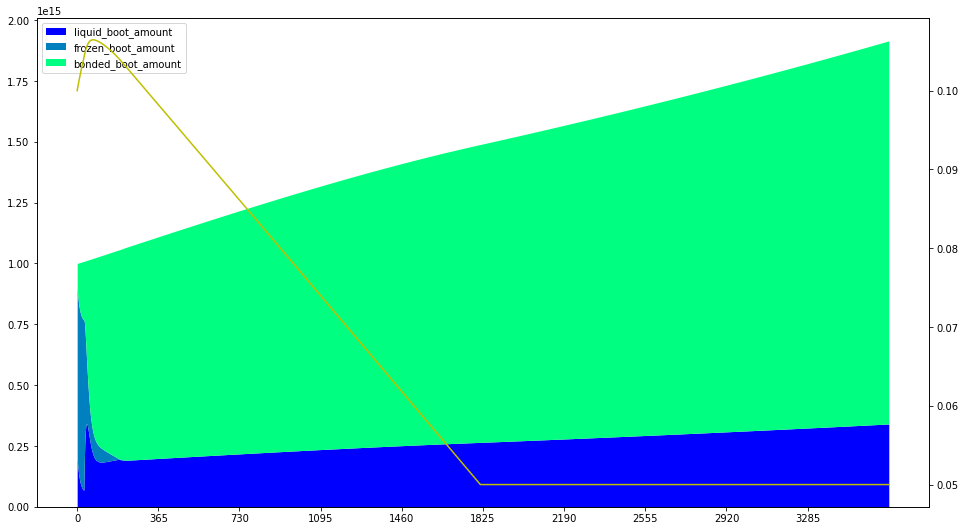

In [14]:
columns = ['liquid_boot_amount', 'frozen_boot_amount', 'bonded_boot_amount']
supply_df = plot_df[columns]
boot_inflation_df = plot_df['boot_inflation']

# supply_df.plot.area()
# plt.show()

ax1 = supply_df.plot.area(linewidth=0, colormap="winter", xticks=range(0, 3650, 365))

ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
boot_inflation_df.plot.line(ax=ax2, figsize=(16,9), style={'boot_inflation': 'y'}, xticks=range(0, 3650, 365))

In [15]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 13.162775993347168 seconds ---


<AxesSubplot:>

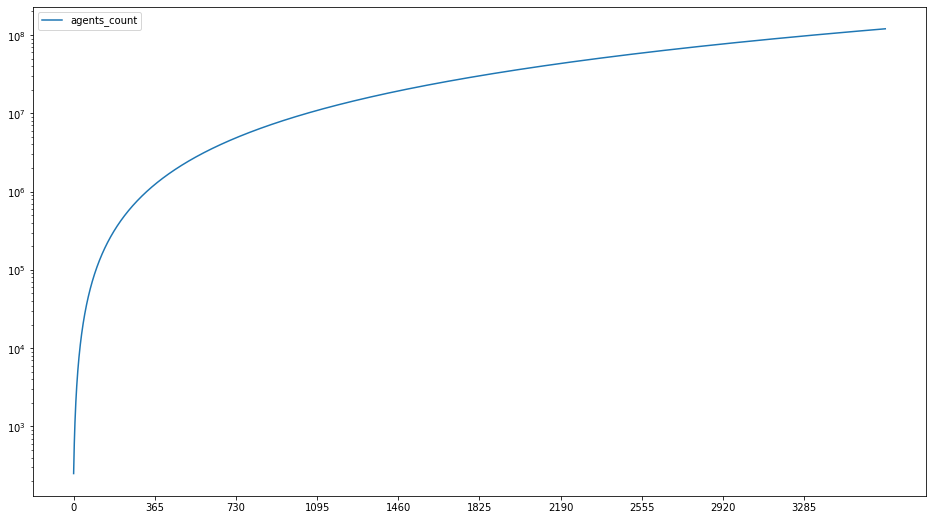

In [16]:
agents_count = plot_df[['agents_count']]
agents_count.plot.line(figsize=(16,9), logy=True, xticks=range(0, 3650, 365))

<AxesSubplot:label='fe3646d3-ad46-457b-adf8-dfdcc2e7f822'>

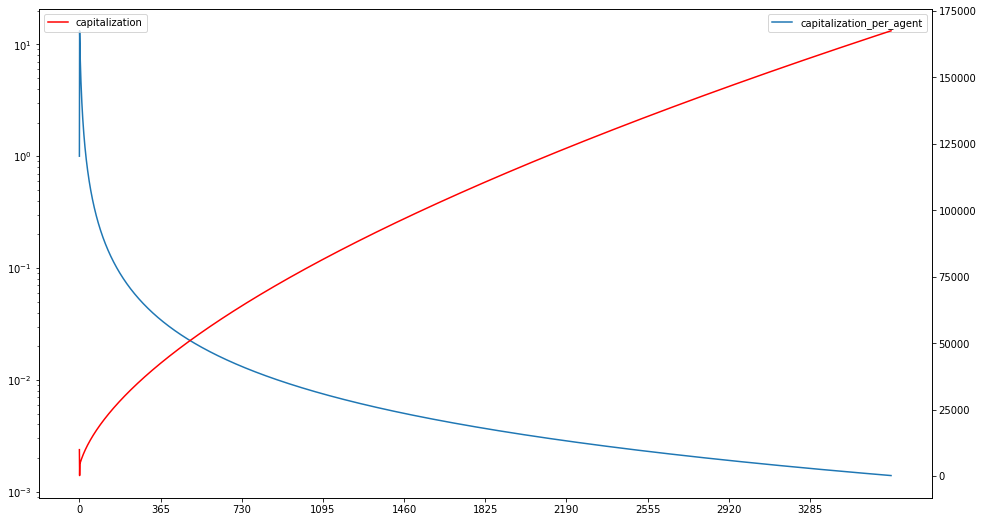

In [17]:
capitalization_per_agent = plot_df[['capitalization_per_agent']]
capitalization = plot_df[['capitalization']]
ax1 = capitalization_per_agent.plot.line(figsize=(16,9), logy=True, xticks=range(0, 3650, 365))
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
capitalization.plot.line(ax=ax2, figsize=(16,9), xticks=range(0, 3650, 365), style={'capitalization': 'r'})

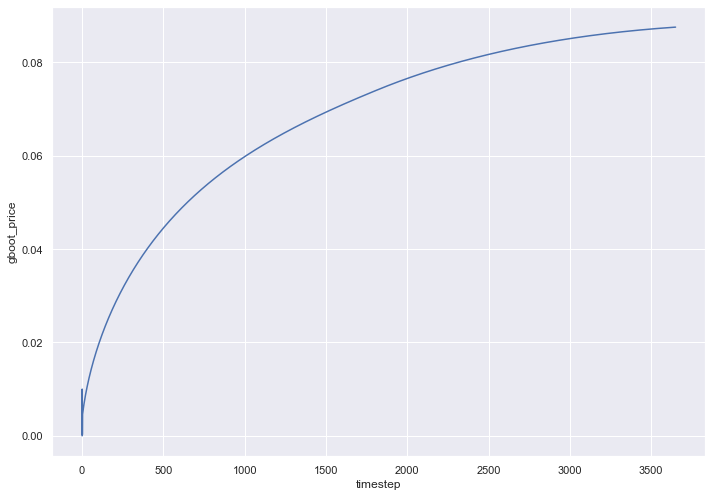

In [18]:
linear_plot(plot_df, 'gboot_price', render='sns')

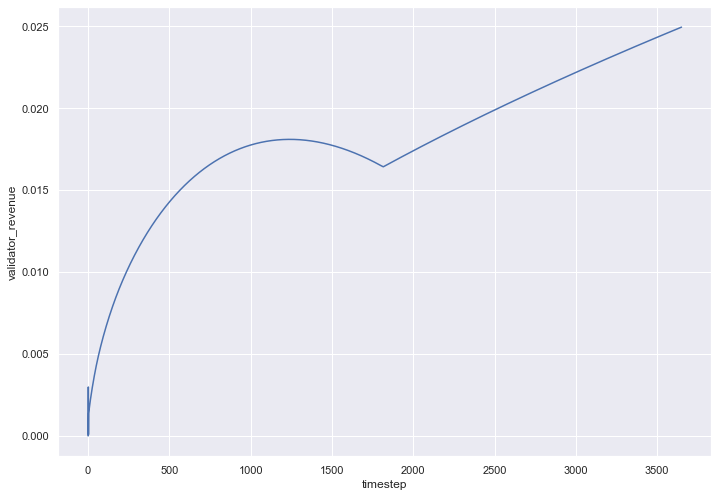

In [19]:
linear_plot(plot_df, 'validator_revenue', render='sns')

In [ ]:
linear_plot(plot_df, 'cyberlinks', render='sns')

In [ ]:
linear_plot(plot_df, 'mint_rate_amper', render='sns')

In [ ]:
linear_plot(plot_df, 'mint_rate_volt', render='sns')

In [ ]:
linear_plot(plot_df, 'investmint_max_period', render='sns')

In [ ]:
linear_plot(plot_df, 'minted_amper_amount', render='sns')

In [ ]:
linear_plot(plot_df, 'minted_volt_amount', render='sns')

In [ ]:
linear_plot(plot_df, 'gpu_memory_usage', render='sns')

In [ ]:
linear_plot(plot_df, 'amper_volt_ratio', render='sns')